# Quantum Hamiltonians simulations

In [505]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import pickle
import glob
import os
import time
from multiprocessing import Pool

import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.contrib.concurrent import process_map as tqdm_parallel

from synthetic_hamiltonians import *

In [507]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

In [3]:
dim = 2
a1 = qt.tensor(qt.destroy(dim), qt.qeye(dim), qt.qeye(dim))
a2 = qt.tensor(qt.qeye(dim), qt.destroy(dim), qt.qeye(dim))
a3 = qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.destroy(dim))

κ=.32
α=.12

comm = qt.commutator(
    κ * (np.exp(1j* α) * a2.dag() * a1 + np.exp(-1j* α) * a1.dag() * a2) +
    κ * (np.exp(1j* α) * a2.dag() * a3 + np.exp(-1j* α) * a3.dag() * a2), 
    1*a1.dag() * a1 + 
    1*a2.dag() * a2 + 
    1*a3.dag() * a3
)
print(np.sum(np.abs(comm.full())))
comm

0.0


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

## Visualization

In [3]:
# def _axes3D(fig, *args, **kwargs):
#     ax = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
#     return fig.add_axes(ax)

# def plot_occupancies_2d_grid(state_constructed, state_actual, n_time_bins=None, n_photons=None, nx=3, ny=3, limits=None):
#     fig = plt.figure(figsize=(20,10))
#     # ax = _axes3D(fig, azim=-35, elev=35)

#     # ax1 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
#     # ax2 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)

#     ax1 = fig.add_subplot(1, 2, 1, projection='3d')
#     ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
#     photon_occupancies_constructed = np.array(get_photon_occupancies(state_constructed, n_time_bins=n_time_bins, n_photons=n_photons, exclude_register=True)).reshape(ny,nx)
#     qt.matrix_histogram(photon_occupancies_constructed,fig=fig, ax=ax1, title="Constructed", colorbar=False, limits=limits)
    
#     photon_occupancies_actual = np.array(get_photon_occupancies(state_actual, n_time_bins=n_time_bins, n_photons=n_photons)).reshape(ny,nx)
#     qt.matrix_histogram(photon_occupancies_actual,fig=fig, ax=ax2, title="Actual", colorbar=False, limits=limits)
    
#     return fig
        
# state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=True)
# state_actual = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=False)

# fig = plot_occupancies_2d_grid(state_constructed, state_actual, limits=[0,2])
# plt.show()

In [4]:
# import glob
# # print(glob.glob("~/Dropbox/Research/quantum-hamiltonians/sim/results/*"))
# print(glob.glob("results/*"))

In [344]:
# Compare ponomarev vs non-ponomarev evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.01
tmax = 1000

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
# state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False, use_ponomarev=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies = np.array(get_photon_occupancies(state_actual_evolved, n_time_bins=D, n_photons=N)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies,fig=fig, ax=ax1, title="Normal", colorbar=False, limits=[0,N])

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax2, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [340]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    # ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [583]:
create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)


TypeError: create_initial_state_all_photons_one_bin() got an unexpected keyword argument 'n_time_bins'

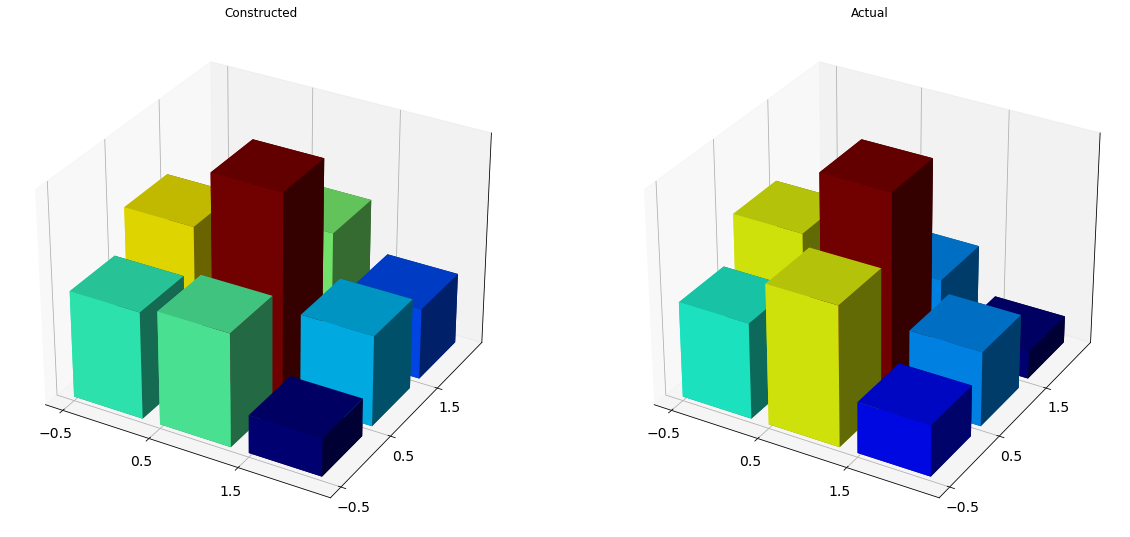

In [29]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.
t = 10

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)
state_constructed_evolved = iteration_op ** t * state_constructed

plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny)

## Animation rendering

In [21]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.1
tmax = 100

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)

cumulative_iteration_op = iteration_op ** 0
for t in tqdm(range(0, tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_constructed_evolved = cumulative_iteration_op * state_constructed
    cumulative_iteration_op *= iteration_op
    # state_constructed_evolved = iteration_op ** t * state_constructed

    fig = plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny, limits=[0,N])
    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [354]:
def hinton(W, xlabels = None, ylabels = None, labelsize = 9, title = None, fig = None, ax = None, cmap = None, color_mode="phase", z_limits=None):

    def _blob(x, y, w, w_min, w_max, area, cmap = None, ax = None):
        """
        Draws a square-shaped blob with the given area (< 1) at
        the given coordinates.
        """
        hs = np.sqrt(area) / 2
        xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
        ycorners = np.array([y - hs, y - hs, y + hs, y + hs])

        handle = ax if ax is not None else plt
        # color = int(256 * (w - w_min) / (w_max - w_min))
        color = (w - w_min) / (w_max - w_min)
        handle.fill(xcorners, ycorners, color = cmap(color))

    if cmap is None:
        cmap = plt.get_cmap('twilight')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    if not (xlabels or ylabels):
        ax.axis('off')

    ax.axis('equal')
    ax.set_frame_on(False)

    height, width = W.shape
    ax.set(xlim = (0, width), ylim = (0, height))

    max_abs = np.max(np.abs(W))
    scale = 0.7

    for i in range(width):
        for j in range(height):
            x = i + 1 - 0.5
            y = j + 1 - 0.5
            if color_mode == "phase":
                _blob(x, height - y, np.angle(W[i, j]), -np.pi, np.pi,
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            elif color_mode == "magnitude":
                if z_limits is None:
                    raise ValueError("Need z limits for magnitude shading")
                _blob(x, height - y, np.abs(W[i, j]), z_limits[0], z_limits[1],
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            else:
                raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # x axis
    ax.xaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    if xlabels:
        ax.set_xticklabels(xlabels, rotation = 'vertical')
        ax.xaxis.tick_top()
    ax.tick_params(axis = 'x', labelsize = labelsize, pad = 0)
    ax.xaxis.set_ticks_position('none')

    # y axis
    ax.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.yaxis.set_ticks_position('none')
    if ylabels:
        ax.set_yticklabels(list(reversed(ylabels)))
    ax.tick_params(axis = 'y', labelsize = labelsize, pad = 0)

    # color axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    if color_mode == "phase":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(-np.pi, np.pi), ticks = [])
        cax.text(0.5, 0.0, '$-\pi$', transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, '$+\pi$', transform = cax.transAxes, va = 'bottom', ha = 'center')
    elif color_mode == "magnitude":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(z_limits[0], z_limits[1]), ticks = [])
        cax.text(0.5, 0.0, str(z_limits[0]), transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, str(z_limits[1]), transform = cax.transAxes, va = 'bottom', ha = 'center')
    else:
        raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # Make title in corner
    if title is not None:
        plt.text(-.07, 1.05, title, ha = 'center', va = 'center', fontsize = 22, transform = ax.transAxes)

    return fig, ax

  0%|          | 0/112 [00:00<?, ?it/s]

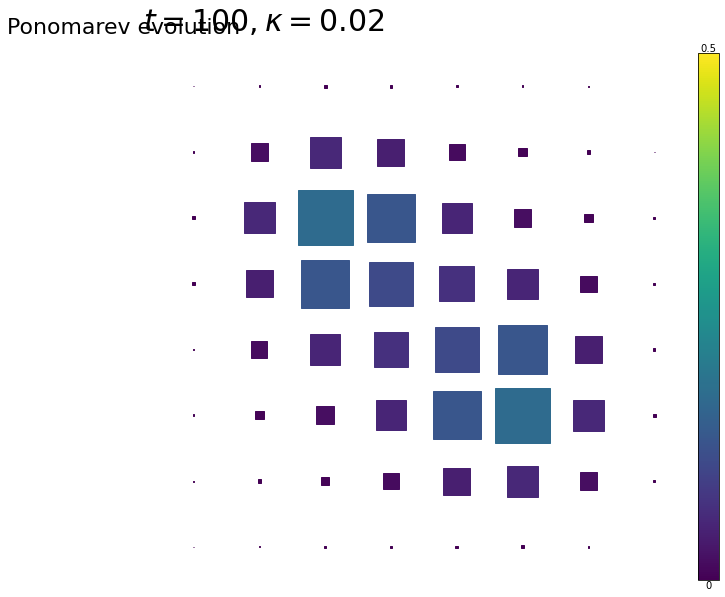

In [358]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

# for t in tqdm(range(0,tmax)):

t= 100
state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')

photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
# qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])
hinton(photon_occupancies_pn, xlabels = None, ylabels = None, labelsize = 9, title = "Ponomarev evolution", fig = fig, ax = ax1, cmap = plt.get_cmap('viridis'), color_mode="magnitude", z_limits=[0, 0.5])

fig.text(0.1, 0.9, f"$t={t}, κ={κ}$", fontsize=30)

title = str(t).zfill(8)
plt.show() 
# plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()

## Time evolved 1D grid plot thingy

In [44]:
def simulate_1d_evolution_and_save(N=2, D=32, κ=0.2, μ=1, U=1, tmax=200, tstep=1, initial_state="same_bin", toroidal=False, use_ponomarev=True):
    
    start = time.time()
        
    # Create initial state
    fock_list = [0] * D
    
    if initial_state == "same_bin":
        photon_location = D // 2
        fock_list[photon_location] = N
    elif initial_state == "close_bins":
        photon_locations = [D//2-1, D//2+1]
        fock_list[photon_locations[0]] = N // 2
        fock_list[photon_locations[1]] = N // 2
    else:
        raise ValueError()
    

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        # state_initial = create_initial_state_all_photons_one_bin(num_sites=D, num_bosons=N, 
        #                                                          full_bin_index=photon_location,
        #                                                          use_ponomarev=use_ponomarev)
        state_initial = qt.basis([N+1] * D, fock_list)
    
    H = BHH_1d_line(D, num_bosons=N,
                    toroidal=toroidal,
                    κ=κ, μ=μ, U=U,
                    include_chemical_potential=True, #(μ != 0.0),
                    include_onsite_interaction=True, #(U != 0.0),
                    use_ponomarev=use_ponomarev,
                    display_progress=False)

    photon_expectations_over_time = []
    states_over_time = []

    for t in tqdm(range(0, tmax, tstep), desc="Evolving states"):
        state_evolved = (-1j * H * t).expm() * state_initial
        states_over_time.append(state_evolved)

    two_photon_correlations_over_time = [get_two_photon_correlations(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    photon_expectations_over_time = [np.array(get_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                     for state in states_over_time]
    double_photon_expectations_over_time = [np.array(get_double_photon_occupancies(state, num_sites=D, num_bosons=N, use_ponomarev=use_ponomarev)) 
                                            for state in states_over_time]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/1d_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{toroidal=}_{initial_state}_results.pickle"
    obj = {
        "state_initial": state_initial,
        "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        "double_photon_expectations_over_time": double_photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")
    
    return filename


In [36]:
# simulate_1d_evolution_and_save(N=2, D=7, κ=0.25, μ=0, U=1e-10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=7, κ=0.25, μ=0, U=10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=7, κ=-0.25, μ=0, U=1e-10, tmax=300, toroidal=False)
# simulate_1d_evolution_and_save(N=2, D=5, κ=-0.25, μ=0, U=-10, tmax=300, toroidal=False, use_ponomarev=False)

In [37]:
def plot_1d_state_evolution(photon_expectations_over_time, 
                            two_photon_correlations_over_time,
                            photon_correlation_snapshots = [0, 5, 15],
                            double_photon_expectations_over_time=None,
                            take_sqrt_of_amplitudes=False,
                            figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .75 * figscale), tight_layout=True)
    if double_photon_expectations_over_time is not None:
        gs = mpl.gridspec.GridSpec(nrows=3, ncols=4, height_ratios = [1.5, 1, 1], width_ratios=[1, 1, 1, 0.05])
    else:
        gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, height_ratios = [1.5, 1], width_ratios=[1, 1, 1, 0.05])
    

    ax = fig.add_subplot(gs[0, :-1])
    cax = fig.add_subplot(gs[0, -1])
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)
    cax2 = fig.add_subplot(gs[1, -1])
    

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.xaxis.tick_top()
    ax.set_xlabel("Time $ t / \\hbar $")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Site index")
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_over_time)), aspect='auto', cmap=cmap)#, vmax=1)#0.5)
    else:
        ax.imshow(np.transpose(photon_expectations_over_time), aspect='auto', cmap=cmap)#, vmax=1)#.5)
        
    max_photons = np.max(photon_expectations_over_time)

    mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])#.5])
    # cax.set_yticklabels(["$0$", "$0.5$"])
    
    mpl.colorbar.ColorbarBase(cax2, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons), ticks = [0, max_photons])
    # cax2.set_yticklabels(["$0$", "$1$"])
        

    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy", rotation=270)
    cax2.get_yaxis().labelpad=8
    cax2.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i \\hat a_j ^\\dagger \\hat a_j \\rangle$", rotation=270)
    
    
    # Add 2-photon correlation subplots
    for i, axis in enumerate([ax1, ax2, ax3]):
        
        if i == 0:
            axis.set_ylabel("$i$")
            axis.set_xlabel("$j$")
            
        if i > 0:
            plt.setp(axis.get_yticklabels(), visible=False)
            axis.set_xlabel("$j$")

    
        time_index = photon_correlation_snapshots[i]
        two_photon_correlations = two_photon_correlations_over_time[time_index]
        axis.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
        axis.text(.97, 0.97, f"$t = {time_index}$", ha = 'right', va = 'top', color="white", transform = axis.transAxes)
        
    if double_photon_expectations_over_time:
        ax_double = fig.add_subplot(gs[2, :-1])
        cax_double = fig.add_subplot(gs[2, -1])
        ax_double.imshow(np.transpose(double_photon_expectations_over_time), aspect='auto', cmap=cmap, vmax=0.5)
        max_photons_double = np.max(double_photon_expectations_over_time)

        mpl.colorbar.ColorbarBase(cax_double, cmap = cmap, norm = mpl.colors.Normalize(0, max_photons_double), ticks = [0, max_photons_double])
        # cax_double.set_yticklabels(["$0$", "$0.5$"])
        
        cax_double.get_yaxis().labelpad=8
        cax_double.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i ^\\dagger  \\hat a_i \\hat a_i \\rangle$", rotation=270)
        

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_from_file(filename, include_description=False, 
                                      photon_correlation_snapshots = [0, 5, 15],
                                      include_two_photon_expectations=False,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    double_photon_expectations_over_time = obj["double_photon_expectations_over_time"] if include_two_photon_expectations else None

    fig = plot_1d_state_evolution(photon_expectations_over_time, two_photon_correlations_over_time, 
                        photon_correlation_snapshots = photon_correlation_snapshots,
                        double_photon_expectations_over_time=double_photon_expectations_over_time,
                        take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                        savefig = savefig)
    
    if include_description:
        # variables = []
        # values = []
        conditions = []
        for txt in filename.split("_"):
            if "=" in txt:
                # variable, value = txt.split("=")
                # variables.append(variable)
                # values.append(value)
                conditions.append(txt)
        description = ", ".join(conditions)
        fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
                
    return fig

Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 8.961330890655518s. Results saved to results/1d_evolution_N=2_D=9_kappa=0.1_mu=array([0., 0., 0., 0., 0., 0., 0., 0., 0.])_U=1_tmax=2000_toroidal=False_same_bin_results.pickle
results/1d_evolution_N=2_D=9_kappa=0.1_mu=array([0., 0., 0., 0., 0., 0., 0., 0., 0.])_U=1_tmax=2000_toroidal=False_same_bin_results.pickle


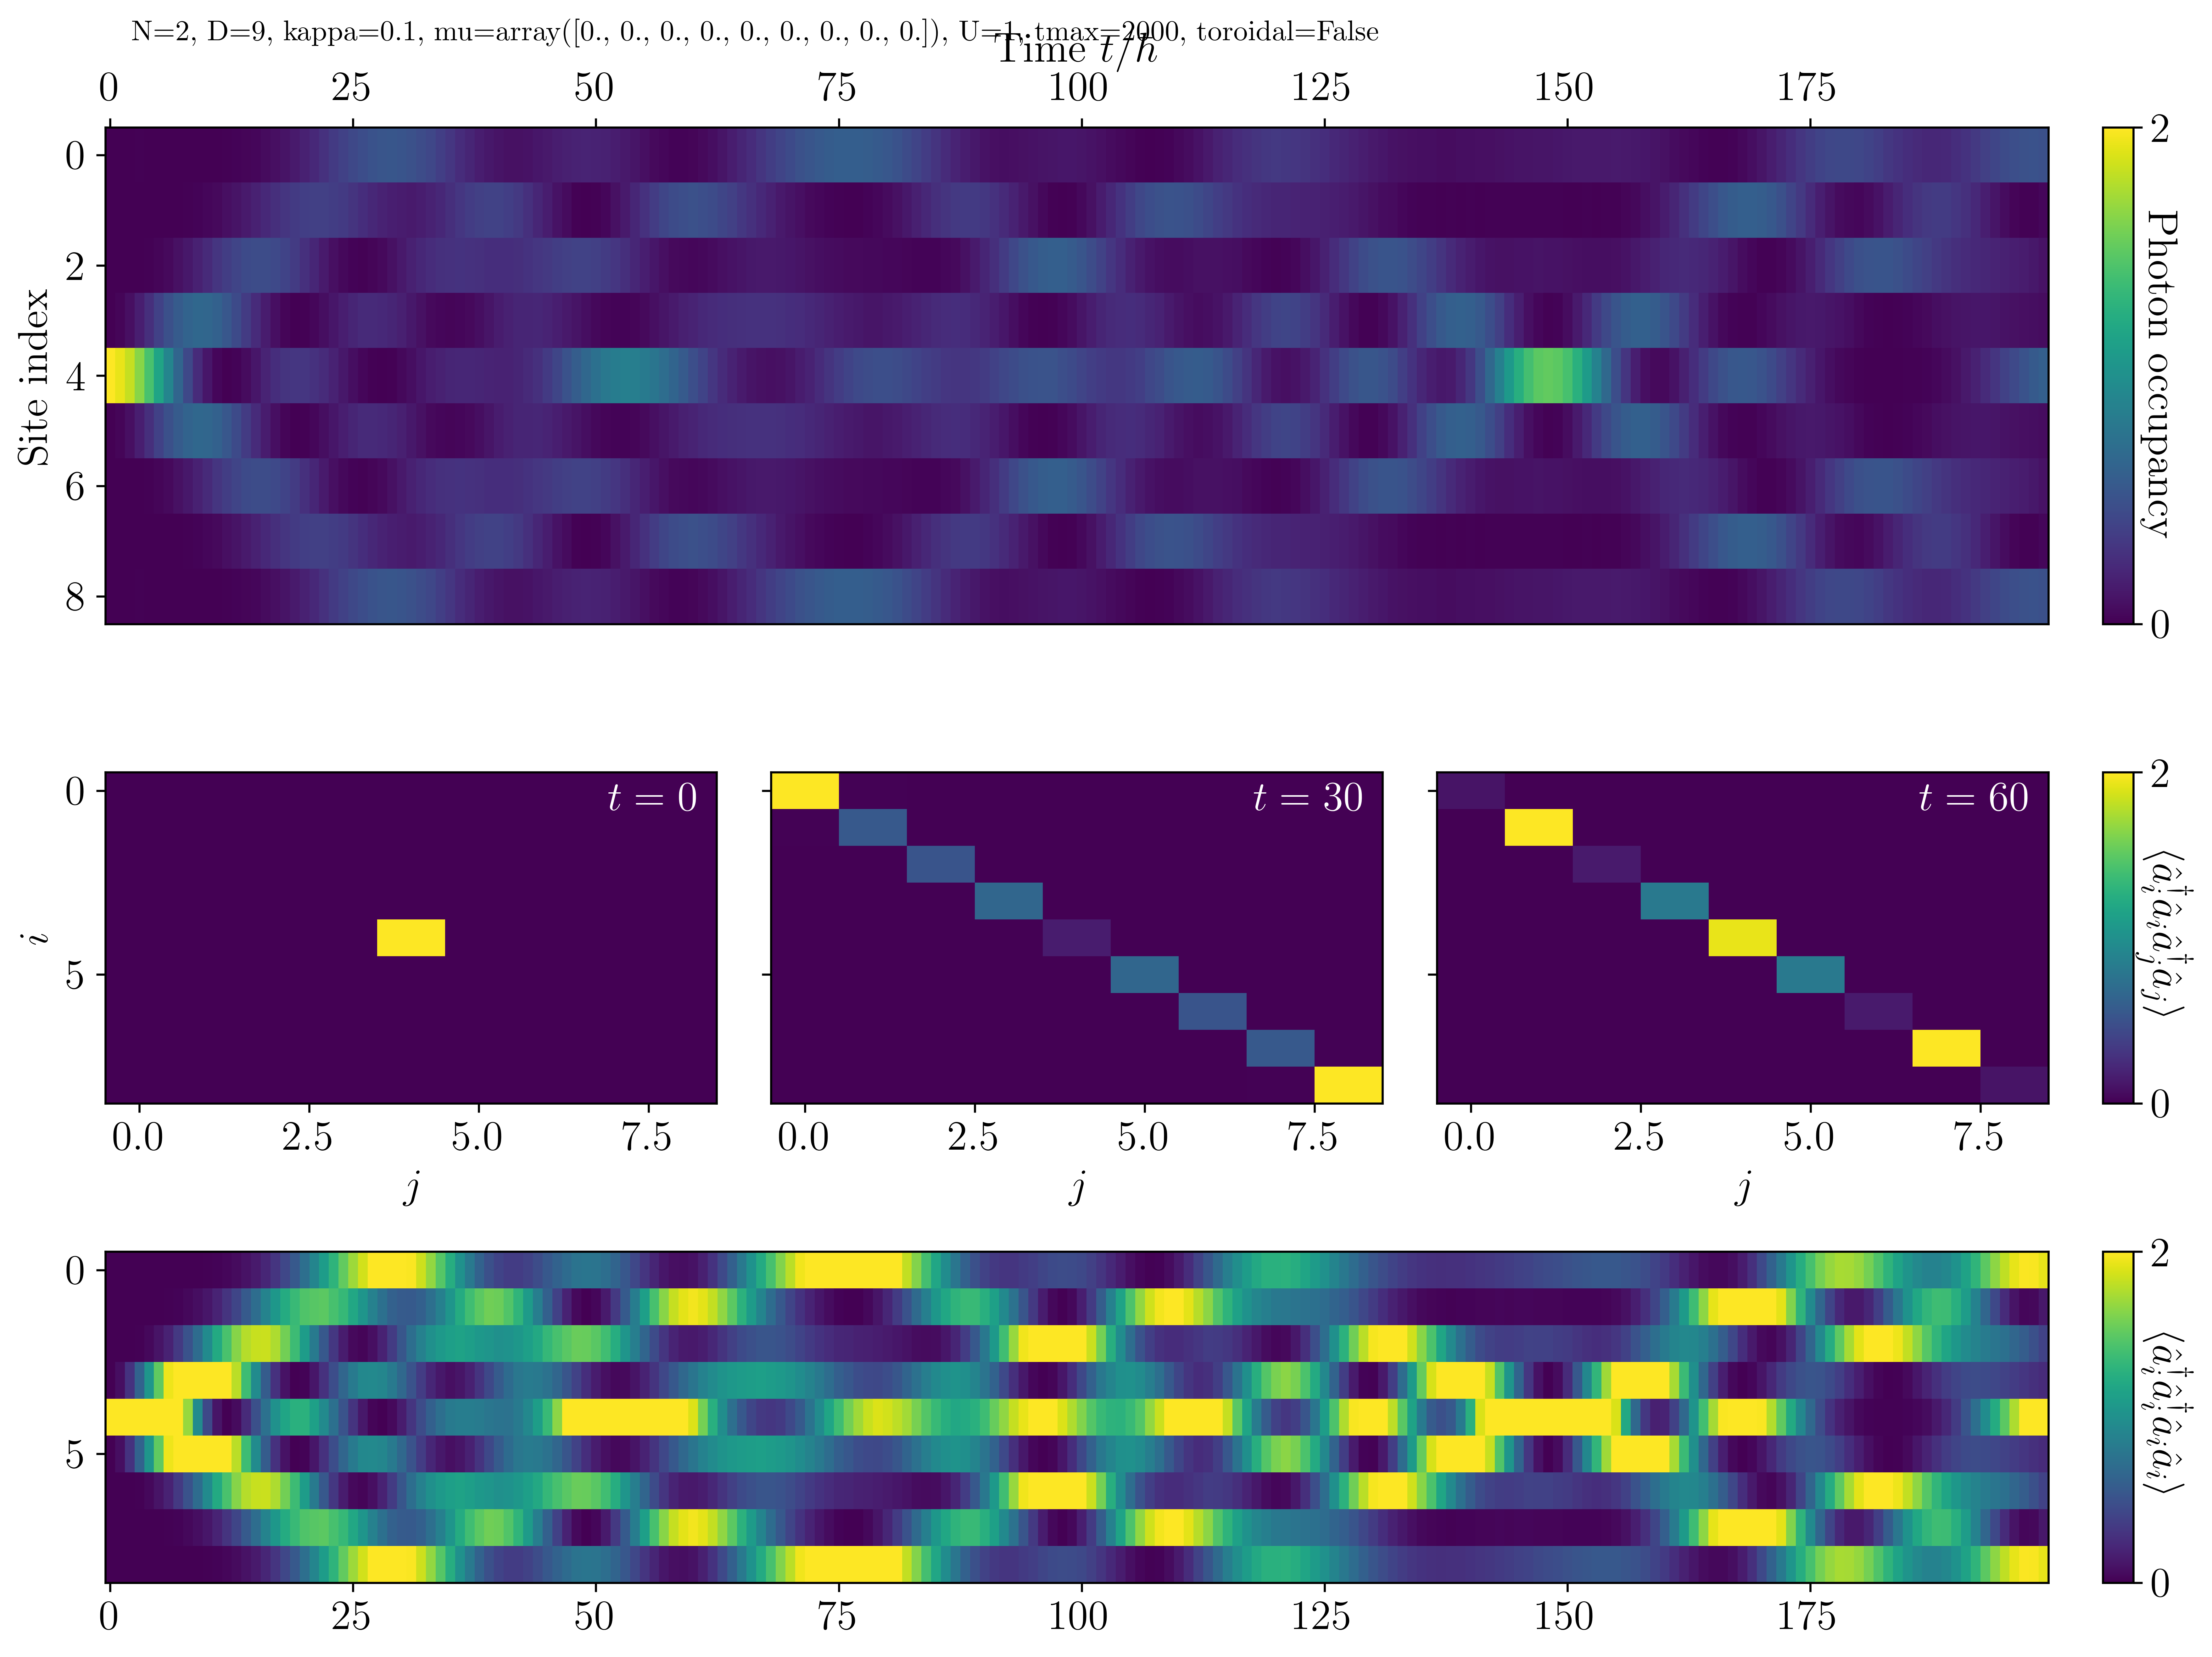

In [34]:
N = 2
D = 15
μ_list = .1 * np.arange(D)
κ = 0.1
tmax = 2000
tstep = 10
state_type = "same_bin"

filenames = [
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=0, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=0, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=0*μ_list, U=-.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True),
    # simulate_1d_evolution_and_save(N=N, D=D, κ=κ, μ=1*μ_list, U=-.1, tmax=tmax, tstep=tstep, initial_state=state_type, toroidal=False, use_ponomarev=True)
]
for filename in filenames:
    print(filename)
    plot_1d_state_evolution_from_file(filename, include_description=True, 
                                      photon_correlation_snapshots = [0, 30, 60],
                                      include_two_photon_expectations=True,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False)
    savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
    plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
    # plt.show()

Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.1287100315094s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1e-10_tmax=200_toroidal=False_same_bin_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.977906942367554s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1_tmax=200_toroidal=False_same_bin_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 14.56722378730774s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1e-10_tmax=200_toroidal=False_close_bins_results.pickle


Evolving states:   0%|          | 0/200 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 15.130862951278687s. Results saved to results/1d_evolution_N=2_D=15_kappa=0.2_mu=0_U=1_tmax=200_toroidal=False_close_bins_results.pickle


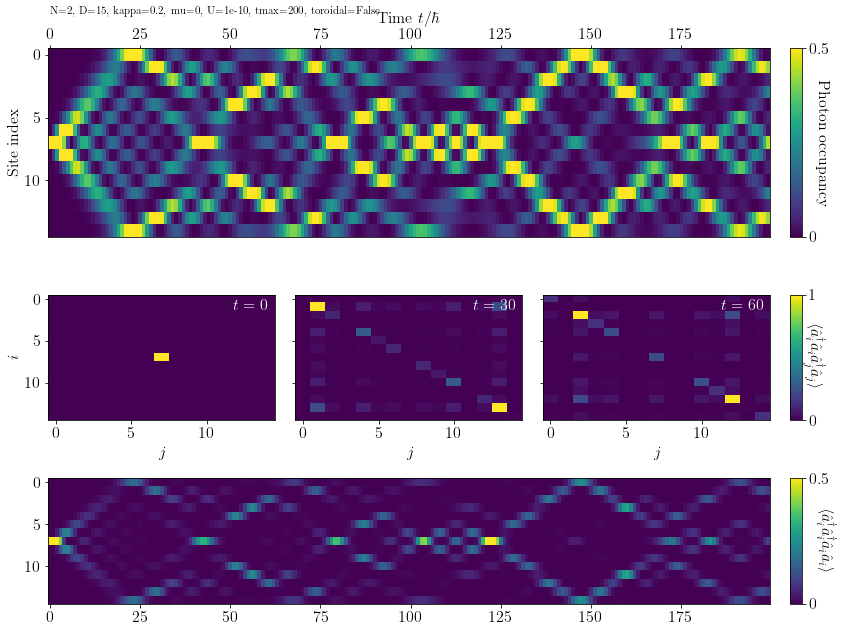

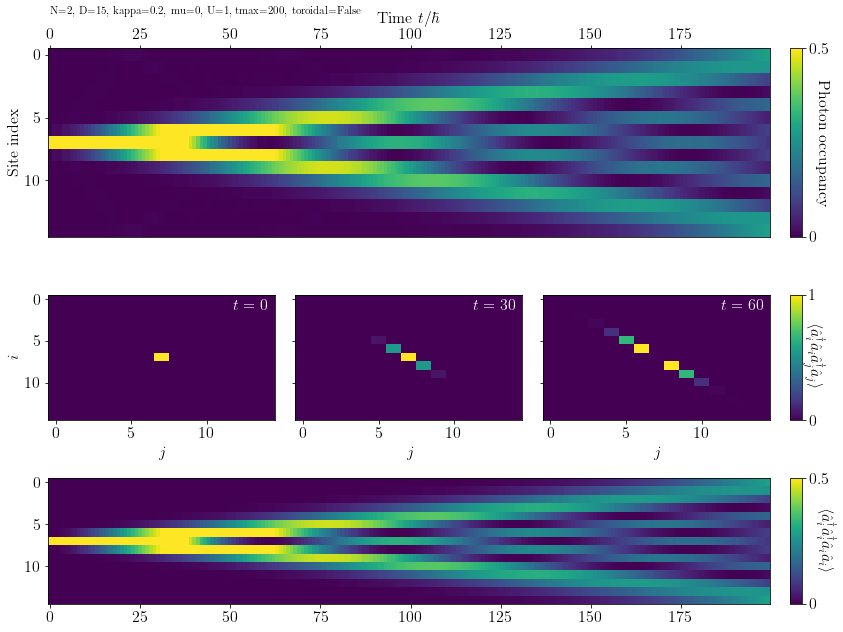

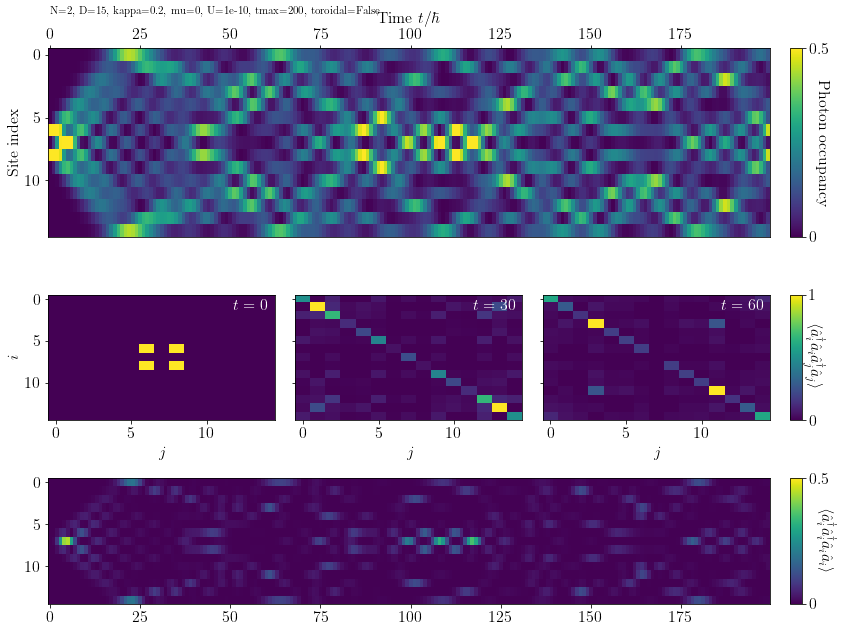

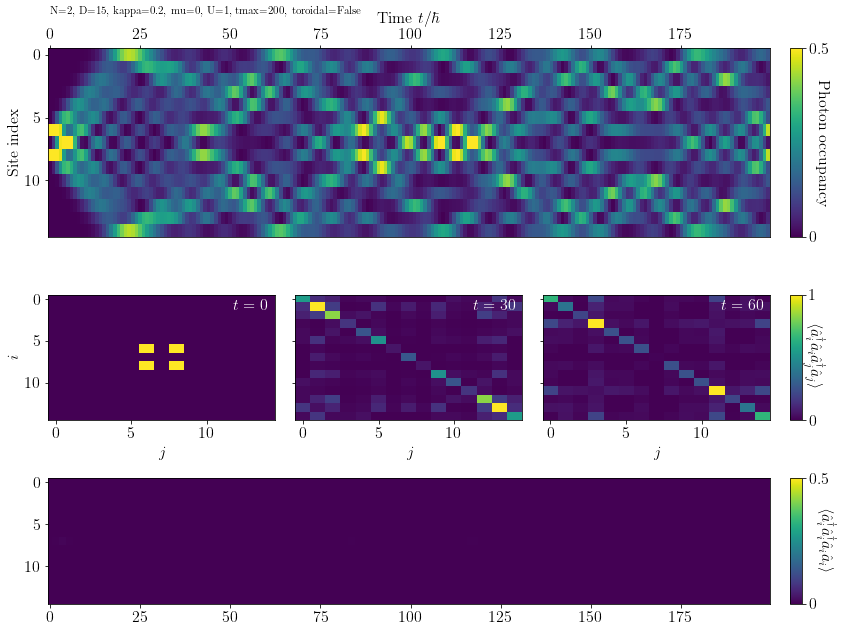

In [15]:
filenames = [
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1e-10, tmax=200, initial_state="same_bin", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1, tmax=200, initial_state="same_bin", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1e-10, tmax=200, initial_state="close_bins", toroidal=False),
    simulate_1d_evolution_and_save(N=2, D=15, κ=0.2, μ=0, U=1, tmax=200, initial_state="close_bins", toroidal=False),
]

for filename in filenames:
    fig = plot_1d_state_evolution_from_file(filename, include_description=True, 
                                      photon_correlation_snapshots = [0, 30, 60],
                                      include_two_photon_expectations=True,
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False)
    savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
    plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
    # plt.show()

In [67]:
def plot_two_photon_correlations(two_photon_correlations):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=14)

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    # Plot state over training
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
    # ax.set_xticks([])
    # ax.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    # ax.yaxis.set_ticks_position('none')
    # ax.set_yticklabels(kets)
    # ax.tick_params(axis = 'y', labelsize = 10, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1),
                                     ticks = [0, 1])
    cax.get_yaxis().labelpad=0
    cax.set_ylabel("Two-photon correlations", rotation=270)
    cax.set_yticklabels(["$0$", "$1$"])
    
    return fig, ax, cax


# plot_two_photon_correlations(two_photon_correlations_over_time[0])
# plt.show()

# plt.savefig("1d_evolution_toroidal.pdf", dpi=300, bbox_inches='tight', pad_inches=0)

In [126]:
def plot_1d_state_evolution_animated(photon_expectations_until_time, 
                                     two_photon_correlations_at_time,
                                     tmax=None,
                                     take_sqrt_of_amplitudes=False,
                                     figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .45 * figscale), tight_layout=True)
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, 
                               width_ratios=[1, 1.2, 0.05], hspace=0.0)#,
                               #hspace=0.1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax = fig.add_subplot(gs[0, 1:-1], sharey=ax1)
    cax = fig.add_subplot(gs[0, -1])

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.set_xlabel("Time $ t / \\hbar $")
    plt.setp(ax.get_yticklabels(), visible=False)
    ax1.set_ylabel("Site index $i$")
    ax1.set_xlabel("Site index $j$")
    
    if tmax is not None:
        ax.set_xlim(0, tmax)
    
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_until_time)), aspect='auto', cmap=cmap)
    else:
        ax.imshow(np.transpose(photon_expectations_until_time), aspect='auto', cmap=cmap)

    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])
    cax.set_yticklabels(["$0$", "$1$"])
    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy, correlation", rotation=270)

    ax1.imshow(two_photon_correlations_at_time, aspect='auto', cmap=cmap)
    time = len(photon_expectations_until_time)
    ax1.text(.97, 0.97, f"$t = {time}$", ha = 'right', va = 'top', color="white", transform = ax1.transAxes)

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_animated_from_file(filename,
                                               t=None,
                                               include_description=False, 
                                               take_sqrt_of_amplitudes=False,
                                               savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    tmax = len(photon_expectations_over_time)
    
    if t == "all" and savefig == True:
        
        # Render *ALL* the frames!
        for t in tqdm(range(1, tmax), desc="Rendering frames"):
        
            fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                                   tmax = tmax-1,
                                                   take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                                                   savefig = False)

            if include_description:
                conditions = []
                for txt in filename.split("_"):
                    if "=" in txt:
                        conditions.append(txt)
                description = ", ".join(conditions)
                fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)

            title = str(t).zfill(8) + "_".join(conditions) + ".png"
            plt.savefig("frames/"+title, bbox_inches='tight', pad_inches=0)
            plt.close()
    
    elif type(t) is int:
    
        fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                               tmax = tmax,
                                               take_sqrt_of_amplitudes=take_sqrt_of_amplitudes)

        if include_description:
            conditions = []
            for txt in filename.split("_"):
                if "=" in txt:
                    conditions.append(txt)
            description = ", ".join(conditions)
            fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
            
    
                
    
filename = "results/1d_evolution_N=2_D=32_kappa=0.2_mu=1_U=1_tmax=100_toroidal=False_results.pickle"
plot_1d_state_evolution_animated_from_file(filename, include_description=True,
                                           t="all",
                                           take_sqrt_of_amplitudes=False,
                                           savefig = True)       
# plt.show()

Rendering frames:   0%|          | 0/99 [00:00<?, ?it/s]

In [4]:
# for filename in glob.glob("results/*"):
#     framename = filename.replace("results/1d_evolution_", "frames/*").replace("_results.pickle", ".png")
#     videoname = filename.replace("results/1d_evolution_", "assets/1d_evolution_").replace("_results.pickle", ".mp4")
#     print(framename)
#     os.system(f'ffmpeg -framerate 60 -pattern_type glob -i "{framename}" -filter:v scale="trunc(oh*a/2)*2:1080" -pix_fmt yuv420p {videoname}')

# Hamiltonian to bandstructure conversion

In [572]:
D = 1000
N = 1
α = -2 * np.pi / 3 
κ = 0.1
μ = 0.0
U = 0.0

H = BHH_ladder(length = D//2, 
               hopping_phase = α,
               # hopping_phase_mode = "rung",
               hopping_phase_mode = "translation_invariant",
               circular = True,
               κ = κ,
               μ = μ,
               U = U,
               num_bosons = N,
               use_ponomarev=True,
               display_progress=True)

eigenvals, eigenkets = H.eigenstates()
# Throw away vacuum state and superfluous final ponomarev index state
eigenvals = eigenvals[1:-1]
eigenkets = eigenkets[1:-1]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [573]:
# Numerically find the value of k for each of the eigenstates
def find_k_for_eigenket(eigenket):
    ket = eigenket.full().flatten()#[1:-1].flatten() # discard vacuum state and superfluous ponomarev index
    
    # ket_even = ket[ : len(ket) // 2]
    # ket_odd = ket[len(ket) // 2 : ]
    
    ket_even = ket[0 : : 2]
    ket_odd = ket[1 : : 2]
    
    freq = np.fft.fftfreq(ket.shape[0])
    freq_even = np.fft.fftfreq(ket_even.shape[0])
    freq_odd = np.fft.fftfreq(ket_odd.shape[0])
    
    max_k = freq[np.argmax(np.abs(np.fft.fft(ket)))]
    max_k_even = freq_even[np.argmax(np.abs(np.fft.fft(ket_even)))]
    max_k_odd = freq_odd[np.argmax(np.abs(np.fft.fft(ket_odd)))]
    # if np.abs(max_k_even) != np.abs(max_k_odd):
    #     raise RuntimeError("huh?")

    # This heuristic actually seems to work very well
    if np.sum(np.abs(ket_even)**2) > np.sum(np.abs(ket_odd)**2):
        return max_k_even
    else:
        return max_k_odd
    # return np.abs(max_k)

def find_even_odd_projection(eigenket):
    ket = eigenket.full().flatten()#[1:-1].flatten()
    ket_even = ket[0 : : 2]
    ket_odd = ket[1 : : 2]
    return np.sum(np.abs(ket_even)**2), np.sum(np.abs(ket_odd)**2)

In [574]:
def convert_scatter_to_line_and_prune_data(k_vals, eigenvals, projections, 
                                           prune_data=True, divide_bands=False, smooth_projections=False, window_size = 5):
    '''
    Converts the two-banded data which would be used as a scatter plot into
    a pair of line plot data. Additionally, removes a few errant points near D//2 
    which don't play nicely with the numerical k-finding approach.
    '''
    
    # First prune errant points
    k_vals_pruned = np.copy(k_vals)
    eigenvals_pruned = np.copy(eigenvals)
    projections_pruned = np.copy(projections)
    
    indices_to_prune = []
    if prune_data:
        for i, (k, E) in enumerate(zip(k_vals, eigenvals)):
            if -0.02 < E < 0.02 and 0.1 < np.abs(k) < 0.9:
                indices_to_prune.append(i)
        if len(indices_to_prune) > 0.01 * len(eigenvals):
            raise RuntimeError(f"Probably pruning too many points! {len(indices_to_prune)}")
        
    k_vals_pruned = np.delete(k_vals_pruned, indices_to_prune)
    eigenvals_pruned = np.delete(eigenvals_pruned, indices_to_prune)
    projections_pruned = np.delete(projections_pruned, indices_to_prune, axis=0)
    
#     if divide_bands is False:
#         # Sort by a heuristic here which will order the top band from left to right then
#         # the botton band from left to right
#         sorter = k_vals_pruned
        
#         k_vals_argsort = np.argsort(k_vals_pruned)
#         k_vals_sorted = k_vals_pruned[k_vals_argsort]
#         eigenvals_sorted = eigenvals_pruned[k_vals_argsort]
#         projections_sorted = projections_pruned[k_vals_argsort]
        
#         return k_vals_sorted, eigenvals_sorted, projections_sorted
        
#     else:
    k_vals_lower = []
    k_vals_upper = []
    eigenvals_lower = []
    eigenvals_upper = []
    projections_lower = []
    projections_upper = []

    # Second divide into two line plots
    for i, (k, E, proj) in enumerate(zip(k_vals_pruned, eigenvals_pruned, projections_pruned)):
        # dividing line is .2 |k| - .1
        if E >= 0.2 * np.abs(k) - 0.1:
            k_vals_upper.append(k)
            eigenvals_upper.append(E)
            projections_upper.append(proj)
        else:
            k_vals_lower.append(k)
            eigenvals_lower.append(E)
            projections_lower.append(proj)

    k_vals_lower = np.array(k_vals_lower)
    k_vals_upper = np.array(k_vals_upper)
    eigenvals_lower = np.array(eigenvals_lower)
    eigenvals_upper = np.array(eigenvals_upper)
    projections_lower = np.array(projections_lower)
    projections_upper = np.array(projections_upper)

    # Finally, sort by k value 
    k_vals_lower_argsort = np.argsort(k_vals_lower)
    k_vals_lower = k_vals_lower[k_vals_lower_argsort]
    eigenvals_lower = eigenvals_lower[k_vals_lower_argsort]
    projections_lower = projections_lower[k_vals_lower_argsort]

    k_vals_upper_argsort = np.argsort(k_vals_upper)
    k_vals_upper = k_vals_upper[k_vals_upper_argsort]
    eigenvals_upper = eigenvals_upper[k_vals_upper_argsort]
    projections_upper = projections_upper[k_vals_upper_argsort]
    
    if smooth_projections:
        def movingaverage(data, window_size):
            window = np.ones(int(window_size))/float(window_size)
            return np.convolve(data, window, 'same')
        projections_upper = np.transpose(projections_upper)
        projections_lower = np.transpose(projections_lower)
        projections_upper[0] = movingaverage(projections_upper[0], window_size)
        projections_upper[1] = movingaverage(projections_upper[1], window_size)
        projections_lower[0] = movingaverage(projections_lower[0], window_size)
        projections_lower[1] = movingaverage(projections_lower[1], window_size)
        projections_upper = np.transpose(projections_upper)
        projections_lower = np.transpose(projections_lower)

    if divide_bands:
        return k_vals_lower, eigenvals_lower, projections_lower, k_vals_upper, eigenvals_upper, projections_upper
    
    else:
        k_vals_sorted = np.concatenate((k_vals_lower, k_vals_upper))
        eigenvals_sorted = np.concatenate((eigenvals_lower, eigenvals_upper))
        projections_sorted = np.concatenate((projections_lower, projections_upper))
        return k_vals_sorted, eigenvals_sorted, projections_sorted

In [575]:
k_vals = np.array([find_k_for_eigenket(eigenket) for eigenket in eigenkets]) * 2
projections = np.array([find_even_odd_projection(eigenket) for eigenket in eigenkets])
even_proj, odd_proj = np.transpose(projections)

In [576]:
# k_vals_lower, eigenvals_lower, projections_lower, k_vals_upper, eigenvals_upper, projections_upper = convert_scatter_to_line_and_prune_data(k_vals, eigenvals, projections)

In [577]:
k_vals, eigenvals, projections = convert_scatter_to_line_and_prune_data(
    k_vals, eigenvals, projections, 
    prune_data=True, divide_bands=False, 
    smooth_projections=False, window_size = int(D/200))
even_proj, odd_proj = np.transpose(projections)

In [582]:
H.type

'oper'

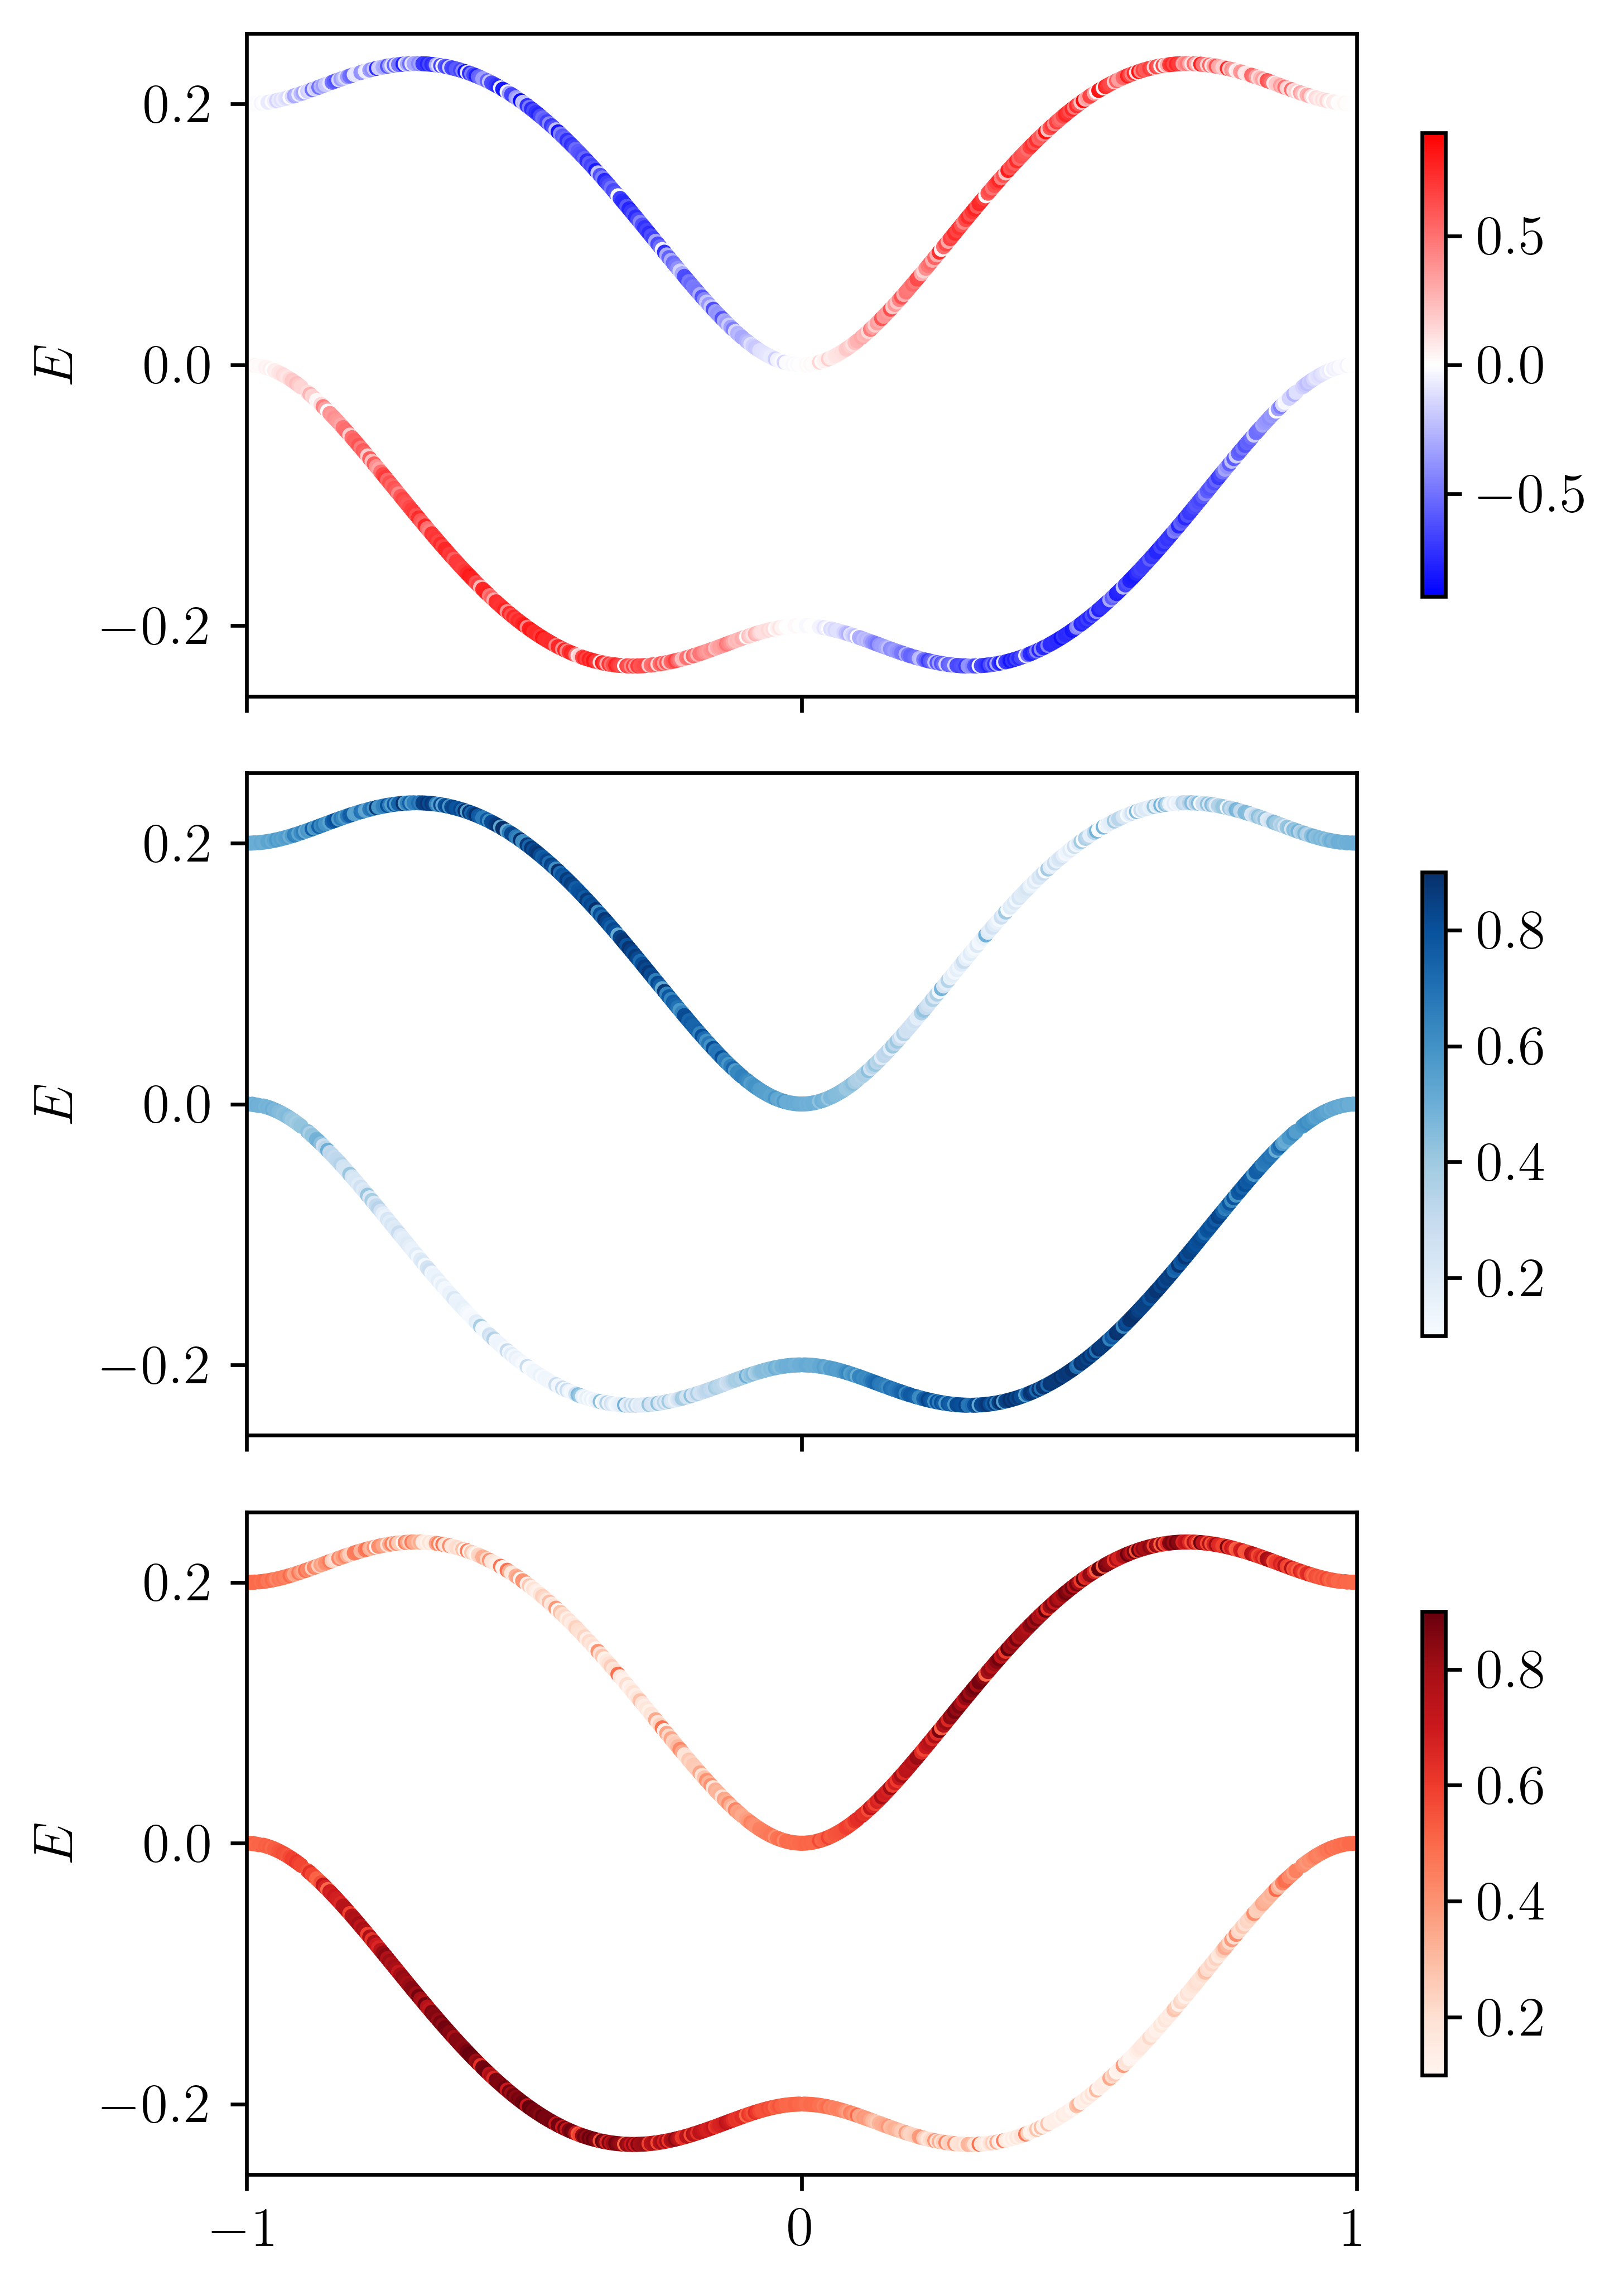

In [578]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, sharex=True, figsize=(5,7))

for ax in [ax1, ax2, ax3]:
    ax.set_xlim([-1, 1])
    ax.set_xticks([-1, 0, 1])
    ax.set_ylabel('$E$')
    # ax.grid(True)


sc1 = ax1.scatter(k_vals, eigenvals, s=5, c=even_proj - odd_proj, cmap="bwr", alpha=1.0)
sc1.set_clim(-0.9, 0.9)
cb1 = plt.colorbar(sc1, ax=ax1, fraction=0.1, shrink=.7)

sc2 = ax2.scatter(k_vals, eigenvals, s=5, c=odd_proj, cmap="Blues")
sc2.set_clim(0.1, 0.9)
cb2 = plt.colorbar(sc2, ax=ax2, fraction=0.1, shrink=.7)

sc3 = ax3.scatter(k_vals, eigenvals, s=5, c=even_proj, cmap="Reds")
sc3.set_clim(0.1, 0.9)
cb3 = plt.colorbar(sc3, ax=ax3, fraction=0.1, shrink=.7)


fig.tight_layout()
# plt.savefig("assets/band_structure_phi_0.66pi.pdf")
plt.show()

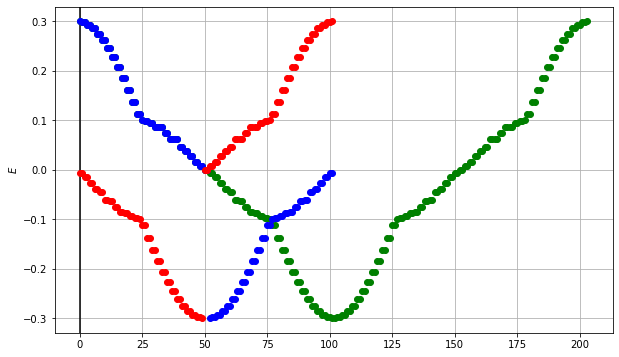

In [37]:
# solve it numerically
evals, ekets = H.eigenstates()

# satisfy periodic boundary conditions we need E(-k) = E(k)
# numerical = evals
numerical = np.concatenate((np.flip(evals, 0), evals), axis=0)
numerical1 = np.concatenate((np.flip(evals[D//2:], 0), evals[:D//2]), axis=0)
numerical2 = np.concatenate((np.flip(evals[:D//2], 0), evals[D//2:]), axis=0)

fig, ax = plt.subplots(figsize=(10,6))
# ax.set_xlim(-np.pi/a, np.pi/a)
# ax.set_title('Tight-Binding Model, $N='+str(N)+', a='+str(a)+'$')
ax.set_ylabel('$E$')
# ax.set_xlabel('$ka$')
ax.axvline(x=0., color='k')

ax.plot(numerical, 'go')
ax.plot(numerical1, 'bo', label='Going up')
ax.plot(numerical2, 'ro', label='Going down')

# ax.plot(k, exact, label='$E(k) = \epsilon_0 - 2 t \cos(ka)$')
# ax.set_yticks([eps-2.*t, eps-t, eps, eps+t, eps+2.*t])
# ax.set_yticklabels(['$\epsilon_0-2t$', '$\epsilon_0-t$', '$\epsilon_0$', '$\epsilon_0+t$', '$\epsilon_0+2t$'])
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabels)
# ax.legend()
ax.grid(True)

In [15]:
# ket = ekets[17]
# ket_first_half = ket.full()[:D//2+1]
# ket_first_half

# # plt.figure(figsize=(2,2))
# plt.plot(np.abs(np.fft.ifft(ket.full()[:D//2+1])))
# # plt.plot(np.real(ket.full()))
# plt.show()

In [292]:
ket = eigenkets[35].full()[1:-1].flatten()
# ket = ket[0 : len(ket)//2]
ket = ket[0 : : 2]
fft = np.fft.fft(ket)
freq = np.fft.fftfreq(ket.shape[0])#, d=1/(2*np.pi))

ket.shape

(150,)

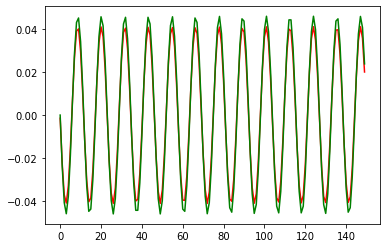

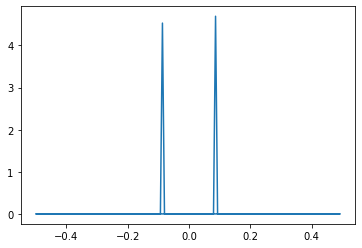

In [293]:


# plt.figure(figsize=(2,2))
plt.plot(ket.real, c="red")
plt.plot(ket.imag, c="green")

# x = np.arange(len(ket))
# y = 0.08 * np.sin(2*np.pi * x/ 33.5) 
# plt.plot(y, c="blue")
plt.show()
# plt.plot(np.imag(ket))

fft = np.fft.fft(ket)
freq = np.fft.fftfreq(ket.shape[0])#, d=1/(2*np.pi))
plt.plot(freq, np.abs(fft))
# plt.plot(freq, np.fft.fft(y))


plt.show()

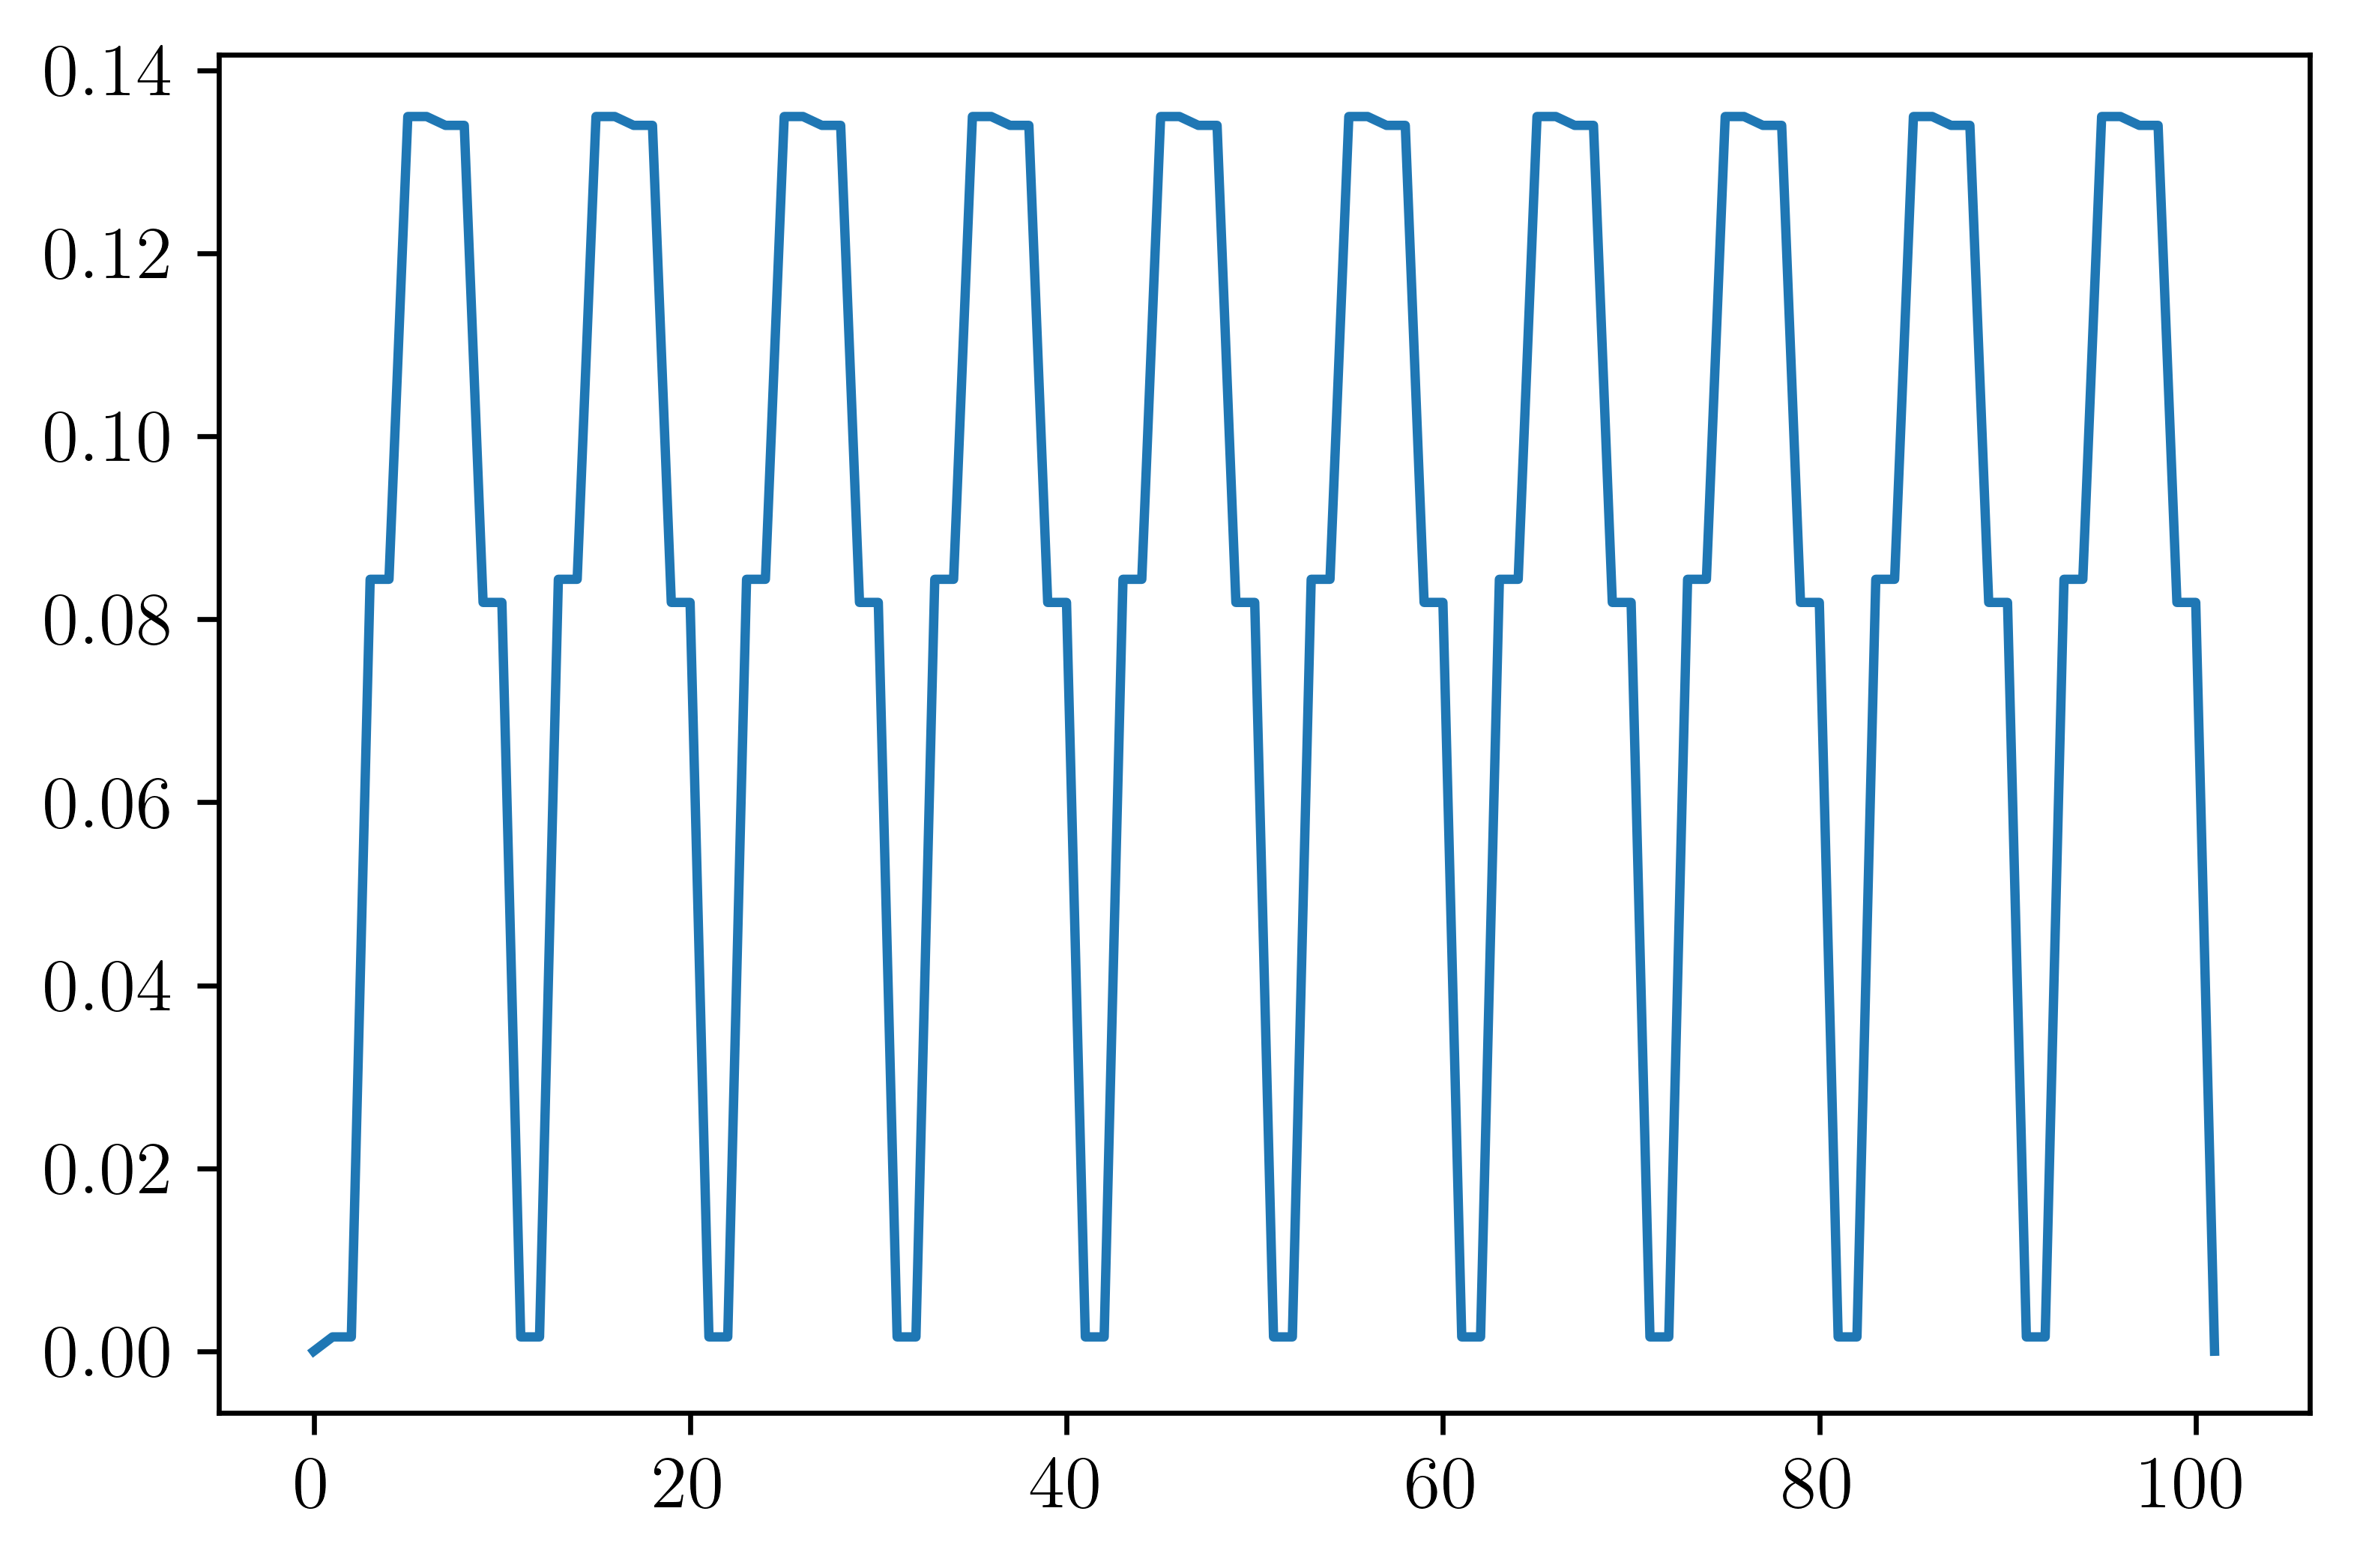

## Simple linear tight-binding model

In [56]:
D = 100
N = 1
α = 0 #np.pi * 1e-10
κ = 0.1
μ = 0.0
U = 0.0

H = BHH_1d_line(num_nodes = D, 
                toroidal = True,
                α=α,
               # hopping_phase = α,
               # hopping_phase_mode = "rung",
               # hopping_phase_mode = "translation_invariant",
               # circular = False,
               κ = κ,
               μ = μ,
               U = U,
               num_bosons = N,
               use_ponomarev=True)

H = H + 1e-6j

In [57]:
H

Quantum object: dims = [[102], [102]], shape = (102, 102), type = oper, isherm = False
Qobj data =
[[ 0. +1.e-06j  0. +0.e+00j  0. +0.e+00j ...  0. +0.e+00j  0. +0.e+00j
   0. +0.e+00j]
 [ 0. +0.e+00j  0. +1.e-06j -0.1+0.e+00j ...  0. +0.e+00j -0.1+0.e+00j
   0. +0.e+00j]
 [ 0. +0.e+00j -0.1+0.e+00j  0. +1.e-06j ...  0. +0.e+00j  0. +0.e+00j
   0. +0.e+00j]
 ...
 [ 0. +0.e+00j  0. +0.e+00j  0. +0.e+00j ...  0. +1.e-06j -0.1+0.e+00j
   0. +0.e+00j]
 [ 0. +0.e+00j -0.1+0.e+00j  0. +0.e+00j ... -0.1+0.e+00j  0. +1.e-06j
   0. +0.e+00j]
 [ 0. +0.e+00j  0. +0.e+00j  0. +0.e+00j ...  0. +0.e+00j  0. +0.e+00j
   0. +1.e-06j]]

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


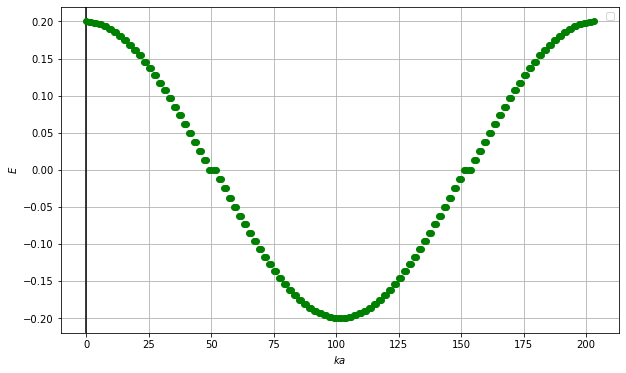

In [53]:
# solve it numerically
evals, ekets = H.eigenstates()

# satisfy periodic boundary conditions we need E(-k) = E(k)
numerical = np.concatenate((np.flip(evals, 0), evals), axis=0)

# numerical1 = np.concatenate((np.flip(evals[50:], 0), evals[:50]), axis=0)
# numerical2 = np.concatenate((np.flip(evals[:50], 0), evals[50:]), axis=0)

fig, ax = plt.subplots(figsize=(10,6))
# ax.set_xlim(-np.pi/a, np.pi/a)
# ax.set_title('Tight-Binding Model, $N='+str(N)+', a='+str(a)+'$')
ax.set_ylabel('$E$')
ax.set_xlabel('$ka$')
ax.axvline(x=0., color='k')

ax.plot(numerical, 'go')

# ax.plot(numerical1, 'bo', label='Going up')
# ax.plot(numerical2, 'ro', label='Going down')

# ax.plot(k, exact, label='$E(k) = \epsilon_0 - 2 t \cos(ka)$')
# ax.set_yticks([eps-2.*t, eps-t, eps, eps+t, eps+2.*t])
# ax.set_yticklabels(['$\epsilon_0-2t$', '$\epsilon_0-t$', '$\epsilon_0$', '$\epsilon_0+t$', '$\epsilon_0+2t$'])
# ax.set_xticks(xticks)
# ax.set_xticklabels(xlabels)
ax.legend()
ax.grid(True)

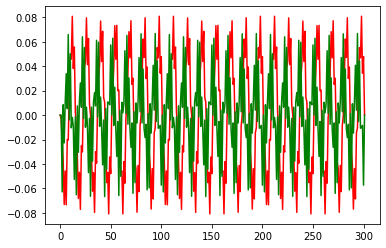

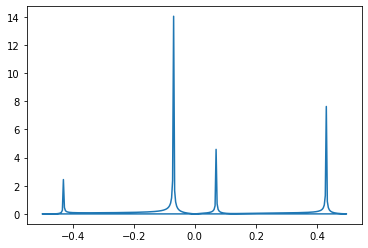

In [281]:
ket = eigenkets[5].full().flatten()

# plt.figure(figsize=(2,2))
plt.plot(ket.real, c="red")
plt.plot(ket.imag, c="green")

# x = np.arange(len(ket))
# y = 0.08 * np.sin(2*np.pi * x/ 33.5) 
# plt.plot(y, c="blue")
plt.show()
# plt.plot(np.imag(ket))

fft = np.fft.fft(ket)
freq = np.fft.fftfreq(ket.shape[0])
plt.plot(freq, np.abs(fft))
# plt.plot(freq, np.fft.fft(y))


plt.show()

In [103]:
ket.shape

(300, 1)

/Users/ben/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


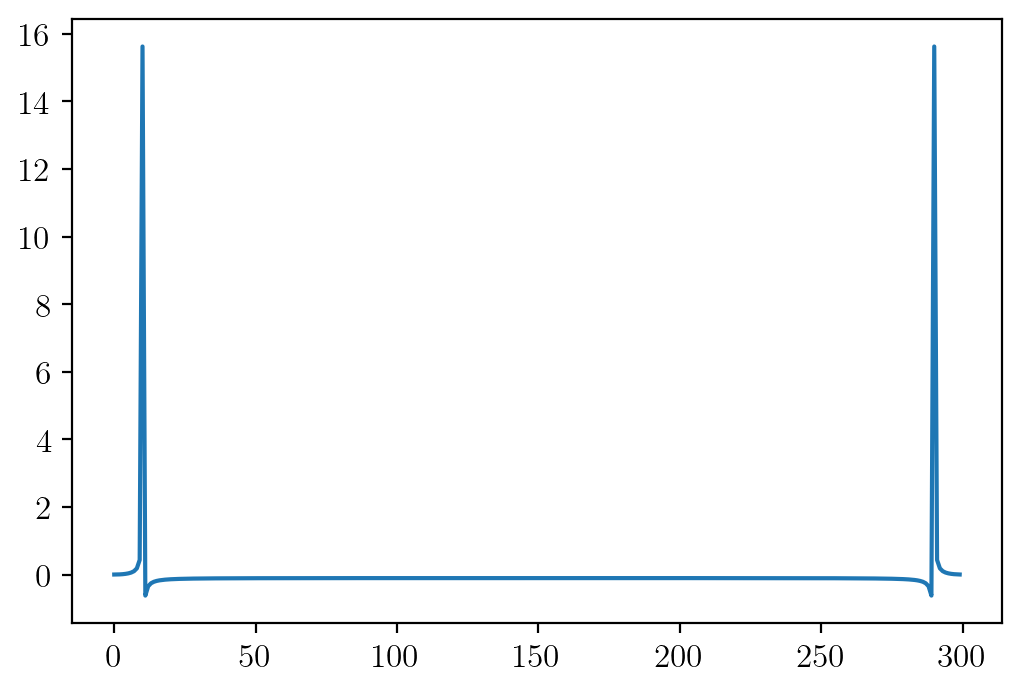

In [70]:
plt.plot(np.fft.fft(np.sin(np.linspace(0, 20*np.pi, 300))))

## Plot code copied from other places

In [ ]:
def plot_frames(filepath, num_qubits=N, num_epochs=None):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train) if num_epochs is None else num_epochs

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
def matrix_histogram(M, xlabels=None, ylabels=None, title=None, limits=None,
                     colorbar=True, fig=None, ax=None):
    """
    Draw a histogram for the matrix M, with the given x and y labels and title.

    Parameters
    ----------
    M : Matrix of Qobj
        The matrix to visualize

    xlabels : list of strings
        list of x labels

    ylabels : list of strings
        list of y labels

    title : string
        title of the plot (optional)

    limits : list/array with two float numbers
        The z-axis limits [min, max] (optional)

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.

    Returns
    -------
    fig, ax : tuple
        A tuple of the matplotlib figure and axes instances used to produce
        the figure.

    Raises
    ------
    ValueError
        Input argument is not valid.

    """

    if isinstance(M, Qobj):
        # extract matrix data from Qobj
        M = M.full()

    n = np.size(M)
    xpos, ypos = np.meshgrid(range(M.shape[0]), range(M.shape[1]))
    xpos = xpos.T.flatten() - 0.5
    ypos = ypos.T.flatten() - 0.5
    zpos = np.zeros(n)
    dx = dy = 0.8 * np.ones(n)
    dz = np.real(M.flatten())

    if isinstance(limits, list) and len(limits) == 2:
        z_min = limits[0]
        z_max = limits[1]
    else:
        z_min = min(dz)
        z_max = max(dz)
        if z_min == z_max:
            z_min -= 0.1
            z_max += 0.1

    norm = mpl.colors.Normalize(z_min, z_max)
    cmap = cm.get_cmap('jet')  # Spectral
    colors = cmap(norm(dz))

    if ax is None:
        fig = plt.figure()
        ax = _axes3D(fig, azim=-35, elev=35)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

    if title and fig:
        ax.set_title(title)

    # x axis
    xtics = -0.5 + np.arange(M.shape[0])
    ax.axes.w_xaxis.set_major_locator(plt.FixedLocator(xtics))
    if xlabels:
        nxlabels = len(xlabels)
        if nxlabels != len(xtics):
            raise ValueError(f"got {nxlabels} xlabels but needed {len(xtics)}")
        ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelsize=14)

    # y axis
    ytics = -0.5 + np.arange(M.shape[1])
    ax.axes.w_yaxis.set_major_locator(plt.FixedLocator(ytics))
    if ylabels:
        nylabels = len(ylabels)
        if nylabels != len(ytics):
            raise ValueError(f"got {nylabels} ylabels but needed {len(ytics)}")
        ax.set_yticklabels(ylabels)
    ax.tick_params(axis='y', labelsize=14)

    # z axis
    ax.axes.w_zaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.set_zlim3d([min(z_min, 0), z_max])

    # color axis
    if colorbar:
        cax, kw = mpl.colorbar.make_axes(ax, shrink=.75, pad=.0)
        mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    return fig, ax

In [ ]:
def plot_qft_figure(filepath, t1 = 0, t2 = 25, tmax = 50, figscale = 12, savefig = False):

    f = h5py.File(filepath, 'r')

    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    fidelity_init = 1 - np.array(f['fidelity_initial'])[-1]
    operator_init = np.array(f['operator_initial'])
    
    fidelities_val = np.insert(fidelities_val, 0, fidelity_init, axis=0)
    fidelities_train = np.insert(fidelities_train, 0, fidelity_init, axis=0)
    operators = np.insert(operators, 0, operator_init, axis=0)
    
    operator_targ = extract_operator_from_circuit(QFT, N)
    kets, bras = computational_basis_labels(N, include_bras=True)

    global_phase1 = np.mean(np.angle(operators[t1]/operator_targ))
    operator1 = operators[t1] / np.exp(1j * global_phase1)

    global_phase2 = np.mean(np.angle(operators[t2]/operator_targ))
    operator2 = operators[t2] / np.exp(1j * global_phase2)
    
    global_phase3 = np.mean(np.angle(operators[tmax]/operator_targ))
    operator3 = operators[tmax] / np.exp(1j * global_phase3)

    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(figscale, figscale*(1/3 + 1/6)), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Plot antifidelity
    fidel_val = fidelities_val[0:tmax+1]
    fidel_train = fidelities_train[0:tmax+1]
    ax_bot = fig.add_subplot(gs[1, :])
    loss_plot(fidel_val, fidel_train, x_units='epochs', x_max = tmax+1, fig=fig, ax=ax_bot, log_fidelity=False)

    # Plot operator visualizations
    fidel1 = fidel_val[t1]
    hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_{"+str(t1)+"}$")
    
    fidel2 = fidel_val[t2]
    hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_{"+str(t2)+"}$")
    
    fidel_3 = fidel_val[tmax]
    hinton(operator3, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\\tilde{U}_{"+str(tmax)+"}$")

    if savefig:
        plt.savefig("assets/qft_3panel.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    
plot_qft_figure('logs/operator_history_4_qubits_2019.08.27.11.03.16.h5', t1=10, t2=20, tmax=50, savefig=False)

## Scratch work

In [85]:
N = 2
a1 = qt.tensor([qt.destroy(N), qt.qeye(N)])
a2 = qt.tensor([qt.qeye(N), qt.destroy(N)])
II = qt.tensor([qt.qeye(N), qt.qeye(N)])
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [86]:
(1j*np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())) + II

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j         -0.13884009+0.13884009j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13884009+0.13884009j  1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [96]:
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [95]:
(1j * np.pi/16 * (a1.dag() * a2 + a1 * a2.dag())).expm() * np.exp(1j*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[2.19328005+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         2.15113679+0.j         0.        +0.42788771j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.42788771j 2.15113679+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  2.19328005+0.j        ]]

In [105]:
(1j * np.pi/4 * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [107]:
(1j * np.pi/4 * (np.exp(-1j*np.pi/4)*a1.dag() * a2 + np.exp(1j*np.pi/4) * a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
 [ 0.        +0.j   0.70710678+0.j  -0.5       +0.5j  0.        +0.j ]
 [ 0.        +0.j   0.5       +0.5j  0.70710678+0.j   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]